<a href="https://colab.research.google.com/github/aparnasree2020/CAS_RPM_2023_GBM/blob/main/GCW_playcode.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Testing manipulations

# Install packages

In [1]:
# Comment after installation so that the whole notebook can be run in one go
# install.packages('gbm')
# install.packages('xgboost')
# install.packages('pROC')
# install.packages('reshape2')
# install.packages('rpart.plot')


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘plyr’, ‘Rcpp’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



# Load Libraries

In [2]:
library(dplyr)
library(tidyverse)
library(xgboost)
library(gbm)
library(reshape2)
library(rpart)
library(rpart.plot)
library(pROC)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.4.1     ✔ purrr   1.0.1
✔ tibble  3.1.8     ✔ stringr 1.4.1
✔ tidyr   1.3.0     ✔ forcats 1.0.0
✔ readr   2.1.4     

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘xgboost’


The following object is masked from ‘package:dplyr’:

    slice


Loaded gbm 2.1.8.1


Attaching package: ‘reshape2’


The following object is masked from ‘package:tidyr’:

    smiths


Type 'citation("pROC")' for a citation.


Attaching package: ‘pROC’


The following objects are masked from 

# Functions

Actual vs Predicted Plot

The A vs E plot function here accepts the dimension variable to review along with the actual and expected response information. The graph will show the ratio of these results to weight. Input actual, expected and weight accordingly. Also, no binning takes place within the code. Please create a binned version for review before passing the information into the function where desired.

In [3]:
## resid.plot includes an off balance for when the model overall predicts low or high
avse.plot.classification <- function(data,var,actual,pred,weight,rt_text,lt_text) {
  header = "Actual vs Predicted"

  home_plot <- data %>%
    mutate(nt = eval(parse(text = var))) %>%
    group_by(nt) %>%
    summarize(  act = sum(eval(parse(text = actual)))
                , pred = sum(eval(parse(text = pred)))
                , exposures = sum(eval(parse(text = weight)))
    ) %>%
    mutate(   actual = act/exposures
              , predicted = pred/exposures)
  
  home_plot <- home_plot[complete.cases(home_plot),]
  
  # off balance for model total prediction
  a1 = paste0("data$",actual)
  a2 = paste0("data$",pred)
  a3 = paste0("data$",weight)
  off_balance = sum(eval(parse(text = a1)))/sum(eval(parse(text = a2)) * eval(parse(text = a3)))
  home_plot$predicted <- home_plot$predicted*off_balance
  
  par(mar=c(5, 4, 2, 5) + 0.1)
  
  barplot(home_plot$exposures,las=2,col="lightblue",ylim = c(0,max(home_plot$exposures)*1.1))
  par(new=TRUE)
  plot(home_plot$nt, home_plot$actual, col='darkblue',lwd= 4, axes=FALSE, ylim=c(ifelse(min(home_plot$actual)<min(home_plot$predicted),min(home_plot$actual)*0.98,min(home_plot$predicted)*0.98),ifelse(max(home_plot$actual)>max(home_plot$predicted),max(home_plot$actual)*1.02,max(home_plot$predicted)*1.02)), xlab="", ylab="",main=header)
  axis(4, ylim=c(0,1),col="black",las=1)
  axis(1, xlim=c(0,1),col="black",las=1)
  mtext(rt_text,side=4,line=3.0,col="black",font=7)
  mtext(lt_text, side = 2, line=3.0,col="black",font=7)
  box()
  mtext(var,side=1,col="black",line=2.5,font=7) 
  lines(home_plot$nt,home_plot$predicted, col="green",lwd=3)  
}


Compute Model Metrics

The following function computes common classification measures for evaluating model results.

In [4]:
# Define a function to compute the metrics for one model
compute_model_metrics <- function(pred, true, var_name) {
  tn <- sum((pred == 0) & (true == 0))
  fp <- sum((pred == 1) & (true == 0))
  fn <- sum((pred == 0) & (true == 1))
  tp <- sum((pred == 1) & (true == 1))
  total <- length(pred)
  
  accuracy <- (tp + tn) / total
  precision <- tp / (tp + fp)
  sensitivity <- tp / (tp + fn)
  f1_score <- 2 * precision * sensitivity / (precision + sensitivity)
  
  roc <- roc(true, pred)
  auc <- auc(roc)
  gini <- (auc * 2) - 1
  
  # Create a data frame to store the metrics
  metrics_df <- data.frame(var_name = var_name,
                           accuracy = accuracy,
                           precision = precision,
                           sensitivity = sensitivity,
                           f1_score = f1_score,
                           roc_auc = auc,
                           gini = gini,
                           TP = tp,
                           FP = fp,
                           TN = tn,
                           FN = fn,
                           Samples = total)
  
  # Return the data frame
  return(metrics_df)
}
# Compute the metrics for each model and combine the resulting data frames
# metrics_df <- rbind(compute_model_metrics(dataout_XGboost_simple$pred_y_test_bin, dataout_XGboost_simple$y_test, "XGBoost"),
                    # compute_model_metrics(dataout_GBM$pred_y_test_bin, dataout_XGboost_simple$y_test, "GBM"),
                    # compute_model_metrics(dataout_GLM$pred_y_test_bin, dataout_GLM$y_test, "GLM"))
#print(metrics_df)

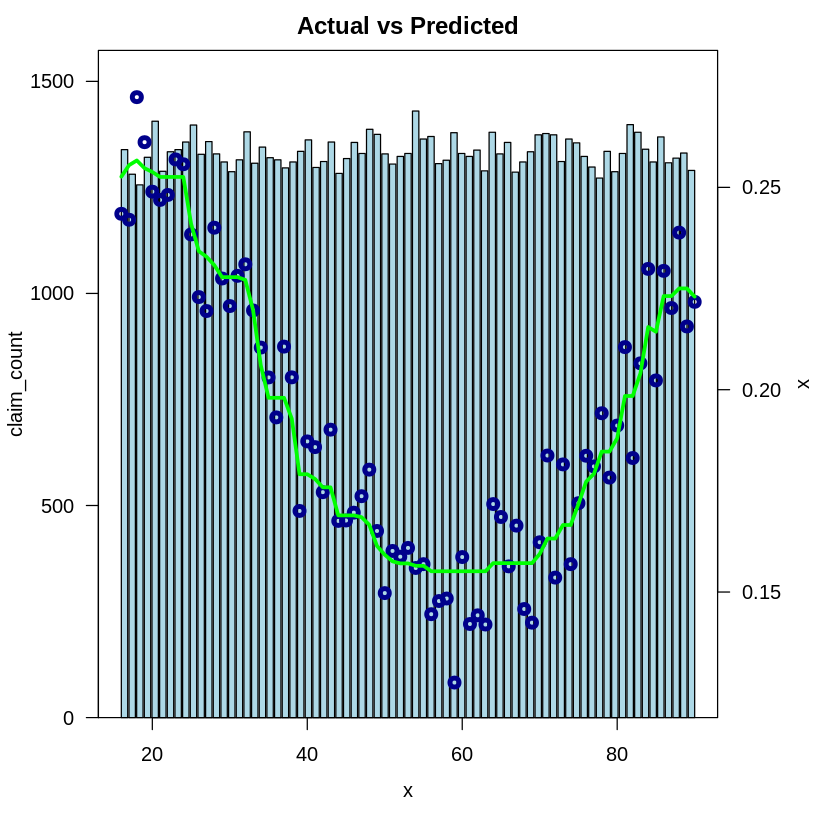

In [ ]:
resid.plot(data=df3,var="x",actual="y.out",pred="pred.gbm",weight="exposures",rt_text="x",lt_text="claim_count")

# Our First GBM (today)

Simulate Some Data

First, we will create a dataset to model on. For our purposes, we'll borrow qualitatively our belief about risk differences by age.


*   Set x to be between 16 and 90
*   Set probability of event to be some form of cosine function
*   Use the probabilities to generate binary outcomes



In [5]:
set.seed(123456)
N <- 100000
x <- sample(16:90, N, replace = TRUE)
y.truth <- (1+0.25*cos((x-15)*pi/45))*.2
y.out <- rbinom(N, 1, prob=y.truth)

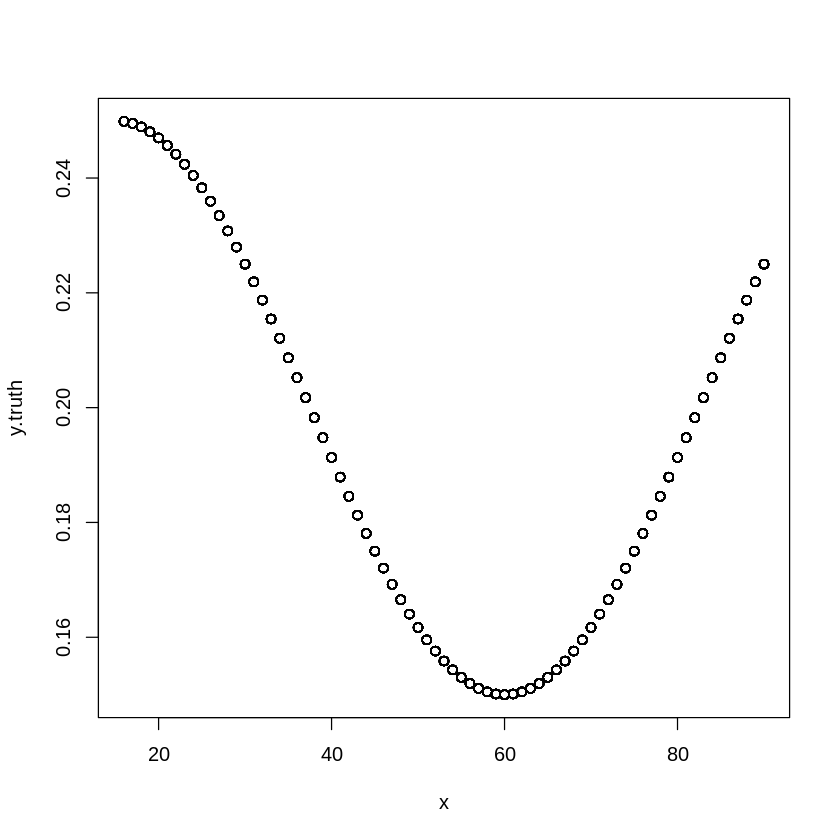

In [6]:
plot(x, y.truth)

In [7]:

df <- data.frame(x, y.truth, y.out)
df2 <- df %>% 
  group_by(x) %>% 
  summarise(reccnt = n(), 
            sum.true = sum(y.truth),
            sum.actual = sum(y.out)) %>%
  mutate(f.true = sum.true / reccnt,
         f.actual = sum.actual / reccnt)
                
              

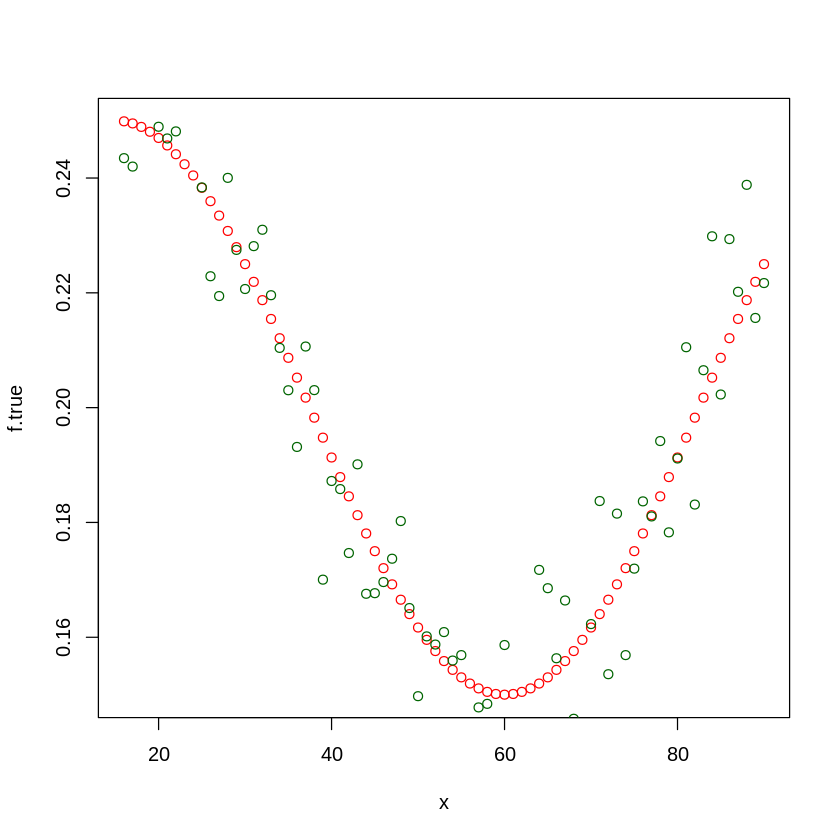

In [8]:
with(df2, plot(x, f.true, col="red"))
with(df2, points(x, f.actual, col="darkgreen"))

In [9]:
m.glm <- glm(y.out ~ x, data=df, family=binomial(link='logit'))
df2$f.predict.glm <- predict(m.glm, newdata=df2, type="response")

In [10]:
summary(m.glm)


Call:
glm(formula = y.out ~ x, family = binomial(link = "logit"), data = df)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-0.7060  -0.6708  -0.6398  -0.6085   1.8961  

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept) -1.1854934  0.0208442  -56.87   <2e-16 ***
x           -0.0047889  0.0003723  -12.86   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 97862  on 99999  degrees of freedom
Residual deviance: 97696  on 99998  degrees of freedom
AIC: 97700

Number of Fisher Scoring iterations: 4


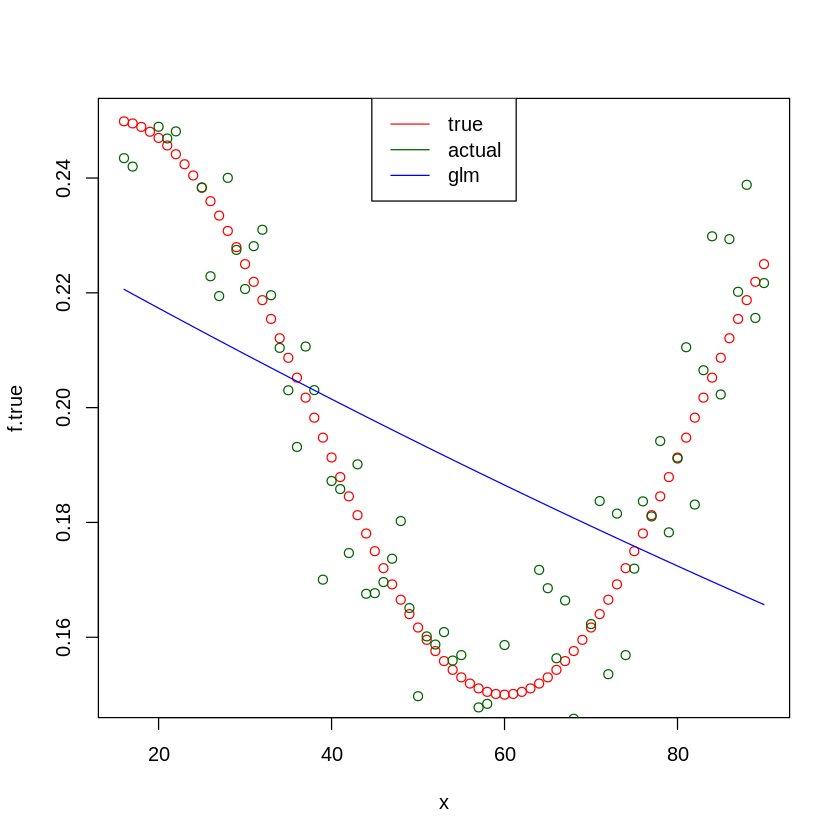

In [11]:
with(df2, plot(x, f.true, col="red"))
with(df2, points(x, f.actual, col="darkgreen"))
with(df2, lines(x, f.predict.glm, lty = 1, col="blue"))
legend("top",
       legend=c("true", "actual", "glm"),
       lty=c(1,1,1),
       col=c("red", "darkgreen", "blue"))

In [12]:

m.glm2 <- glm(y.out ~ poly(x,2), data=df, family=binomial(link='logit'))
m.glm3 <- glm(y.out ~ poly(x,3), data=df, family=binomial(link='logit'))
df2$f.predict.glm2 <- predict(m.glm2, newdata=df2, type="response")
df2$f.predict.glm3 <- predict(m.glm3, newdata=df2, type="response")

In [13]:
summary(m.glm2)
summary(m.glm3)


Call:
glm(formula = y.out ~ poly(x, 2), family = binomial(link = "logit"), 
    data = df)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-0.8267  -0.6669  -0.6127  -0.5907   1.9158  

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept)  -1.448934   0.008112 -178.61   <2e-16 ***
poly(x, 2)1 -29.929361   2.435432  -12.29   <2e-16 ***
poly(x, 2)2  57.003997   2.478275   23.00   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 97862  on 99999  degrees of freedom
Residual deviance: 97175  on 99997  degrees of freedom
AIC: 97181

Number of Fisher Scoring iterations: 4



Call:
glm(formula = y.out ~ poly(x, 3), family = binomial(link = "logit"), 
    data = df)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-0.7875  -0.6788  -0.6083  -0.5795   1.9341  

Coefficients:
              Estimate Std. Error  z value Pr(>|z|)    
(Intercept)  -1.450207   0.008123 -178.534  < 2e-16 ***
poly(x, 3)1 -31.351490   2.443430  -12.831  < 2e-16 ***
poly(x, 3)2  57.625604   2.477414   23.260  < 2e-16 ***
poly(x, 3)3  15.996423   2.479634    6.451 1.11e-10 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 97862  on 99999  degrees of freedom
Residual deviance: 97133  on 99996  degrees of freedom
AIC: 97141

Number of Fisher Scoring iterations: 4


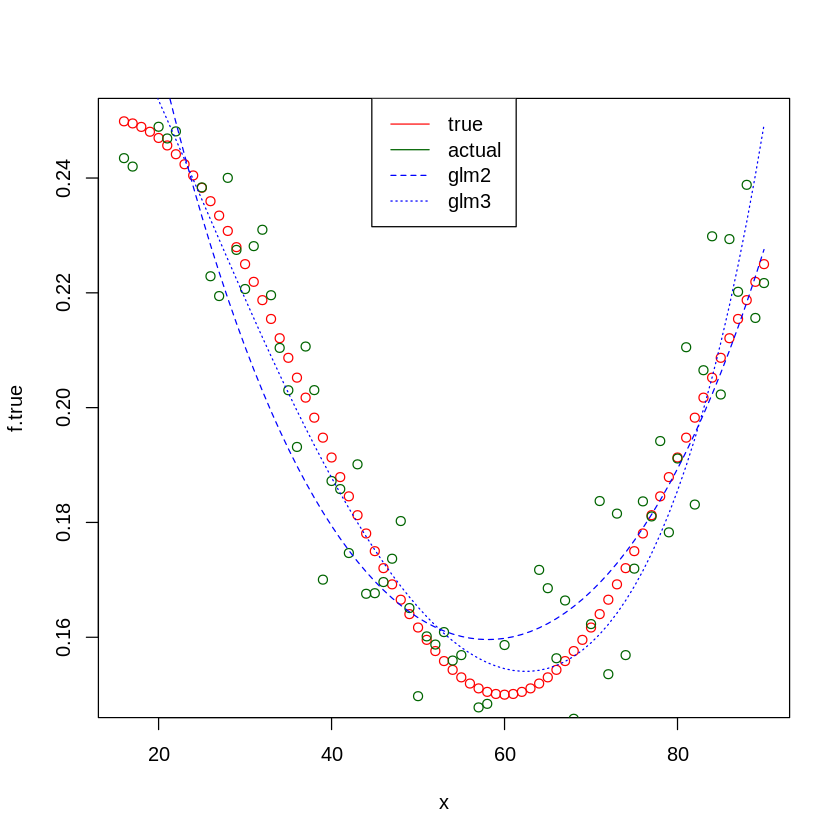

In [14]:
with(df2, plot(x, f.true, col="red"))
with(df2, points(x, f.actual, col="darkgreen"))
with(df2, lines(x, f.predict.glm2, lty = 2, col="blue"))
with(df2, lines(x, f.predict.glm3, lty = 3, col="blue"))
legend("top",
       legend=c("true", "actual", "glm2", "glm3"),
       lty=c(1,1,2:3),
       col=c("red", "darkgreen", "blue", "blue"))

In [15]:

m.glm9 <- glm(y.out ~ poly(x,9), data=df, family=binomial(link='logit'))
df2$f.predict.glm9 <- predict(m.glm9, newdata=df2, type="response")

In [16]:
summary(m.glm9)


Call:
glm(formula = y.out ~ poly(x, 9), family = binomial(link = "logit"), 
    data = df)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-0.7691  -0.6916  -0.6109  -0.5713   1.9495  

Coefficients:
             Estimate Std. Error  z value Pr(>|z|)    
(Intercept)  -1.45098    0.00813 -178.482  < 2e-16 ***
poly(x, 9)1 -31.08599    2.44019  -12.739  < 2e-16 ***
poly(x, 9)2  58.64343    2.51008   23.363  < 2e-16 ***
poly(x, 9)3  15.83011    2.50473    6.320 2.61e-10 ***
poly(x, 9)4 -11.71416    2.51071   -4.666 3.08e-06 ***
poly(x, 9)5  -2.35795    2.50731   -0.940    0.347    
poly(x, 9)6  -2.11818    2.50699   -0.845    0.398    
poly(x, 9)7   0.08949    2.50673    0.036    0.972    
poly(x, 9)8  -3.42477    2.49786   -1.371    0.170    
poly(x, 9)9  -0.60849    2.49605   -0.244    0.807    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 97862  on 99999  degrees of f

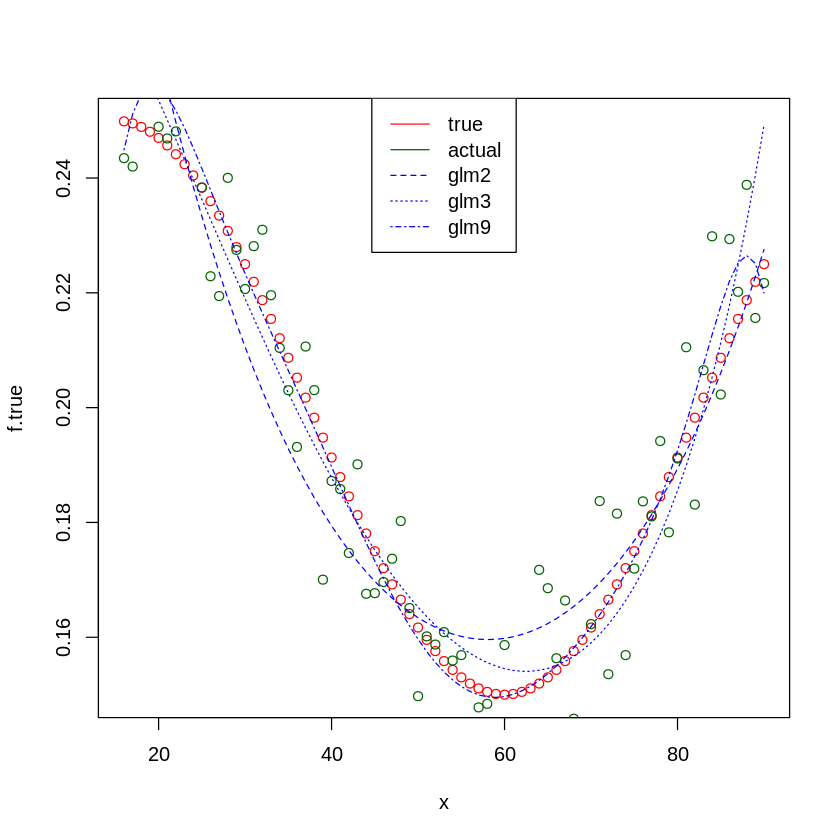

In [17]:
with(df2, plot(x, f.true, col="red"))
with(df2, points(x, f.actual, col="darkgreen"))
with(df2, lines(x, f.predict.glm2, lty = 2, col="blue"))
with(df2, lines(x, f.predict.glm3, lty = 3, col="blue"))
with(df2, lines(x, f.predict.glm9, lty = 4, col="blue"))
legend("top",
       legend=c("true", "actual", "glm2", "glm3", "glm9"),
       lty=c(1,1,2:4),
       col=c("red", "darkgreen", "blue", "blue", "blue"))

Now, let's turn our attention to the GBM. Without knowing much else about GBM, let's use as many defaults as we can, and just send the data through the function. Well, except I allowed myself the choice of distribution.

In [18]:
m.gbm = gbm(y.out ~ x,
            data = df,
            distribution = "bernoulli")
df2$f.predict.gbm <- predict(m.gbm, newdata=df2, type="response")

Using 100 trees...




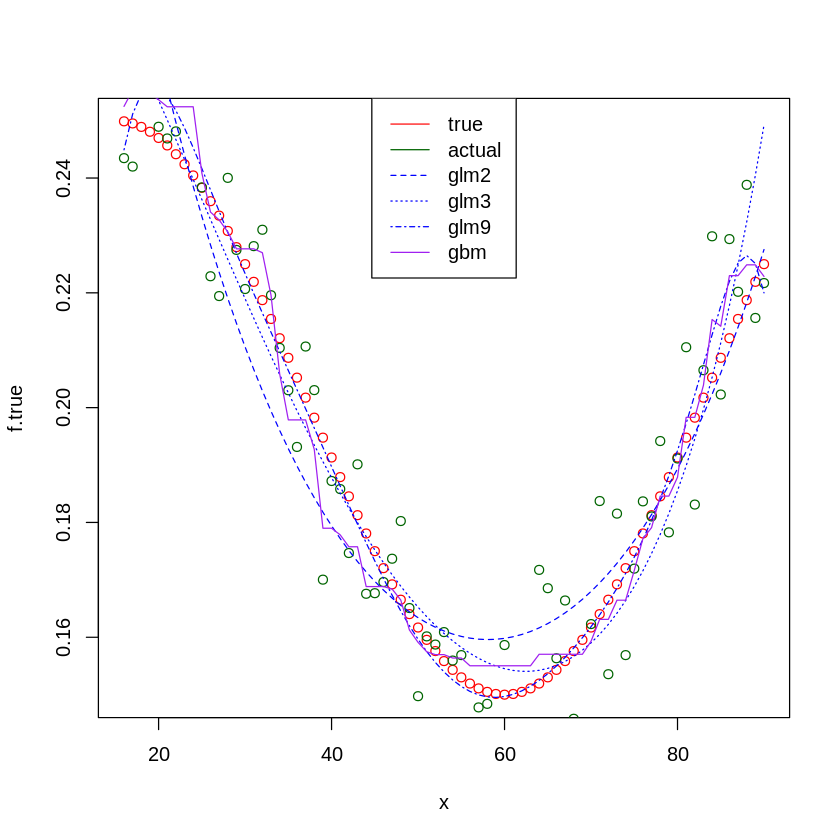

In [19]:
with(df2, plot(x, f.true, col="red"))
with(df2, points(x, f.actual, col="darkgreen"))
with(df2, lines(x, f.predict.glm2, lty = 2, col="blue"))
with(df2, lines(x, f.predict.glm3, lty = 3, col="blue"))
with(df2, lines(x, f.predict.glm9, lty = 4, col="blue"))
with(df2, lines(x, f.predict.gbm, lty = 1, col="purple"))
legend("top",
       legend=c("true", "actual", "glm2", "glm3", "glm9", "gbm"),
       lty=c(1,1,2:4,1),
       col=c("red", "darkgreen", "blue", "blue", "blue", "purple"))

Congrats. There's your first GBM (of today).

In [ ]:
df3 <- df
df3$pred.gbm <- predict(m.gbm, df3, type="response")

Using 100 trees...




In [ ]:
head(df3)

,x,y.truth,y.out,y.gbm.s0,y.gbm.s1,y.gbm.s2,pred.gbm,exposures
,<int>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,75,0.1750000,1,-1.436165,-1.44772,-1.456446,0.1716375,1
2,57,0.1510926,0,-1.436165,-1.44772,-1.456446,0.1550335,1
3,86,0.2120961,0,-1.436165,-1.44772,-1.456446,0.2229949,1
4,69,0.1595492,1,-1.436165,-1.44772,-1.456446,0.1570375,1
5,89,0.2219186,1,-1.436165,-1.44772,-1.456446,0.2248796,1
6,18,0.2489074,0,-1.436165,-1.41278,-1.383688,0.2564830,1


In [ ]:
df3$exposures = 1.0

# An Illustrative Introduction to the GBM Algorithm [Possibly pivot here - we can get iterative results using n.trees and that might be better than trying to build by hand. And, there might not be enough time for this anyway]

We are about to step through a GBM exercise by hand (by R, really). Through this exercise, we aim to familiarize everyone with the concepts behind the algorithms. The current state of art of GBM's are more nuanced than what we're about to go through.

In case we need the original controls back:

rpart.control(minsplit = 20, minbucket = round(minsplit/3), cp = 0.01, 
              maxcompete = 4, maxsurrogate = 5, usesurrogate = 2, xval = 10,
              surrogatestyle = 0, maxdepth = 30)

In [ ]:
m.tree <- rpart(y.out ~ x, data = df, cp = 0.0001, maxcompete = 4, maxdepth = 30)
df2$f.predict.tree <- predict(m.tree, df2)

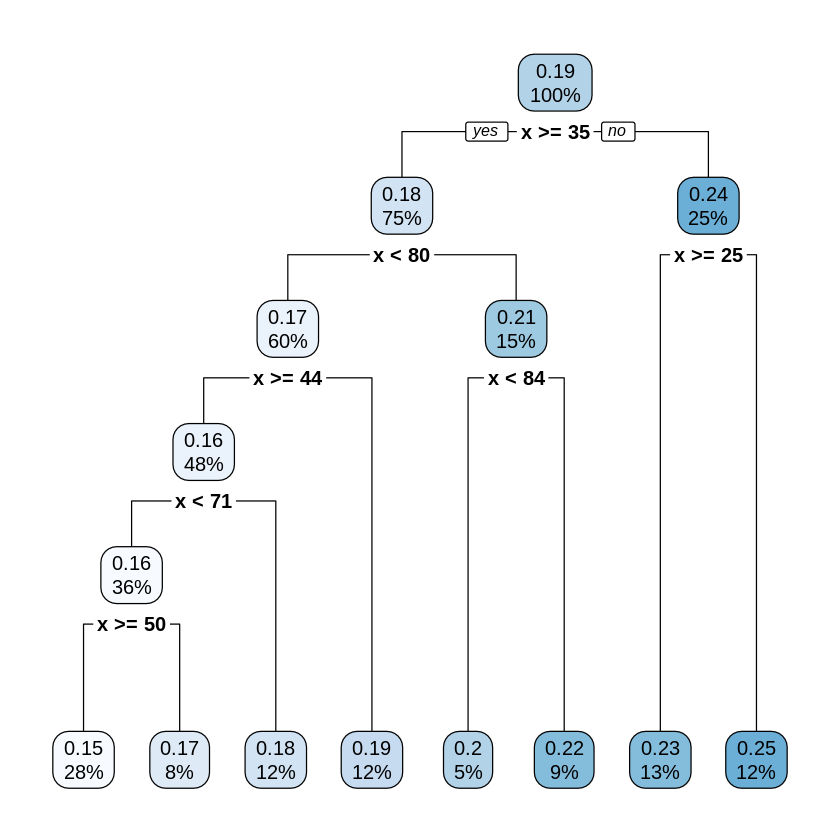

In [ ]:
rpart.plot(m.tree)

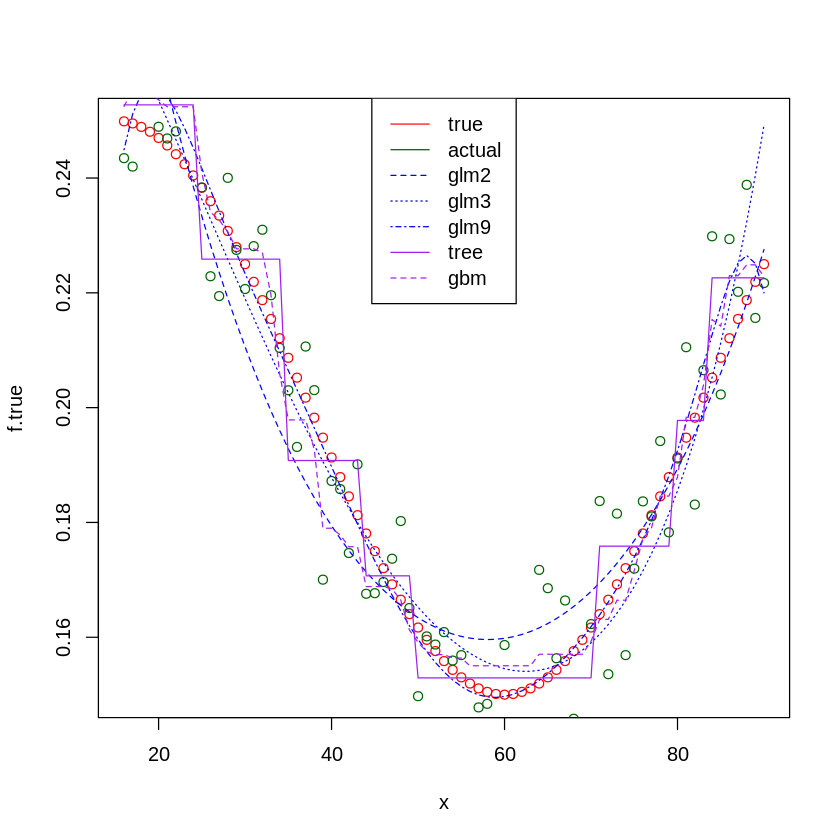

In [ ]:
with(df2, plot(x, f.true, col="red"))
with(df2, points(x, f.actual, col="darkgreen"))
with(df2, lines(x, f.predict.glm2, lty = 2, col="blue"))
with(df2, lines(x, f.predict.glm3, lty = 3, col="blue"))
with(df2, lines(x, f.predict.glm9, lty = 4, col="blue"))
with(df2, lines(x, f.predict.tree, lty = 1, col="purple"))
with(df2, lines(x, f.predict.gbm, lty = 2, col="purple"))
legend("top",
       legend=c("true", "actual", "glm2", "glm3", "glm9", "tree", "gbm"),
       lty=c(1,1,2:4,1:2),
       col=c("red", "darkgreen", "blue", "blue", "blue", "purple", "purple"))

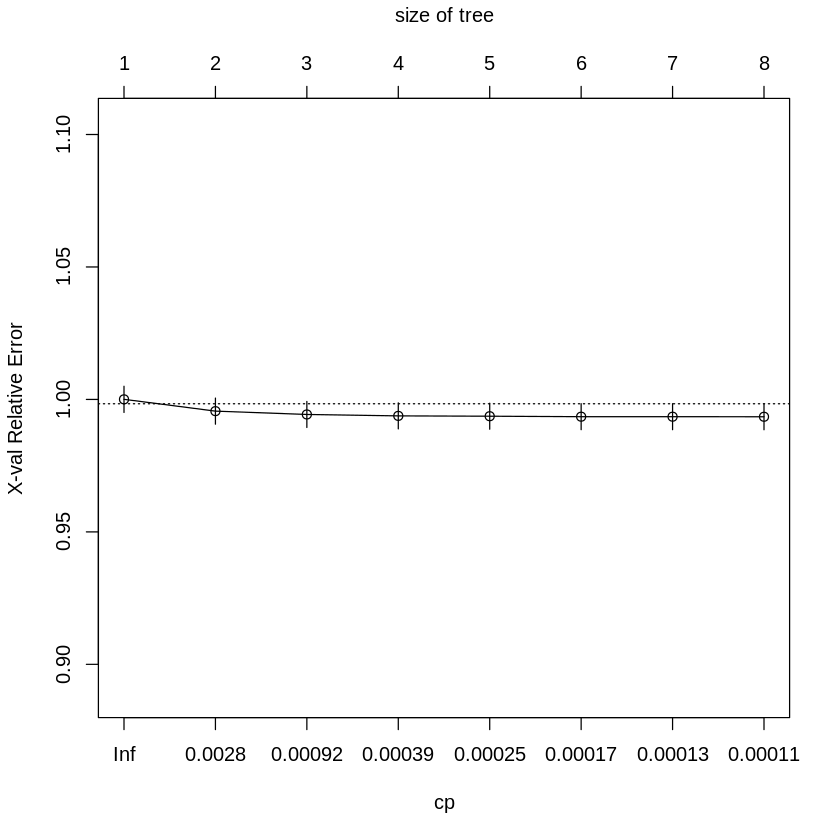

In [ ]:
plotcp(m.tree)

# A Classification Example (Harder)

The classification example is actually harder than the regression example, because dealing with probabilities and the log-odds is harder than dealing with averaging of expected values. Still, it's worth doing once just so we get a sense of what an iteration is. I just hope I get it right!

Let's start with a base model, and just compute an overall probability from our data

In [ ]:
temp <- df %>%
  summarise(reccnt = n(),
            sum.actual = sum(y.out)) %>%
  mutate(p = sum.actual / reccnt)
base.prob <- temp$p
rm(temp)
base.odds <- base.prob/(1-base.prob)
log.base.odds <- log(base.odds)

In [ ]:
c(base.prob, base.odds, log.base.odds)

[1]  0.1921400  0.2378382 -1.4361645

The code will predict the complement, since the chance of positive outcome is less than 0.5.

In [ ]:
df$y.gbm.s0 <- predict.gbm(m.gbm, df, n.trees=0)
df$y.gbm.s1 <- predict.gbm(m.gbm, df, n.trees=1)
df$y.gbm.s2 <- predict.gbm(m.gbm, df, n.trees=2)

In [ ]:
pretty.gbm.tree(m.gbm, i.tree=1)

,SplitVar,SplitCodePred,LeftNode,RightNode,MissingNode,ErrorReduction,Weight,Prediction
,<int>,<dbl>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>
0,0,38.5000000000,1,2,3,31.2123,50000,-0.0008761632
1,-1,0.0233849805,-1,-1,-1,0.0000,15282,0.0233849805
2,-1,-0.0115553152,-1,-1,-1,0.0000,34718,-0.0115553152
3,-1,-0.0008761632,-1,-1,-1,0.0000,50000,-0.0008761632


In [ ]:
head(df, 20)

,x,y.truth,y.out,y.gbm.s0,y.gbm.s1,y.gbm.s2
,<int>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
1,75,0.1750000,1,-1.436165,-1.44772,-1.456446
2,57,0.1510926,0,-1.436165,-1.44772,-1.456446
3,86,0.2120961,0,-1.436165,-1.44772,-1.456446
4,69,0.1595492,1,-1.436165,-1.44772,-1.456446
5,89,0.2219186,1,-1.436165,-1.44772,-1.456446
6,18,0.2489074,0,-1.436165,-1.41278,-1.383688
7,82,0.1982550,0,-1.436165,-1.44772,-1.456446
8,38,0.1982550,0,-1.436165,-1.41278,-1.421505
9,82,0.1982550,0,-1.436165,-1.44772,-1.456446


# A Regression Example (Easier)

# Simulated Example of the Day

Now, we're going to take the gbm for a spin. Our simulated example above is nice for an introduction, but is too trivial for my taste. Let's put something together a bit closer to what we would typically run.

For explorations, we will create the following data:
*   Age
*   Gender (y-correlated with Age)
*   Marital Status (exposure correlated with Age)
*   Tenure (some correlation with age)
*   Prior Claims (simulate multiple periods to compute)
*   Years Claim Free (simulate multiple periods to compute)
*   Territory (simple - Urban High/Low and Rural High/Low)
*   Vehicle Type (Sedan, Minivan, Trucks - Minivan corr w/MS and Trucks corr w/Terr)
*   Three generic - strong/moderate/moderate
*   Six generic - 3 weak, 3 no effect


Let's start by generating the portfolio. We'll create enough records to separate into a robust train and test set.

In [179]:
N <- 200000
# Set up probabilities for Age
tmp1 <- 16:90
tmp2 <- tmp1 - 53
tmp3 <- tmp2 / 37
tmp4 <- dnorm(tmp3, 0, 1)
tmp5 <- sum(tmp4)
p.Age <- tmp4 / tmp5
rm(tmp1, tmp2, tmp3, tmp4, tmp5)
# End p.Age setup
x.Age <- sample(16:90, N, replace=TRUE, prob=p.Age)
x.Gender.M <- sample(0:1, N, replace=TRUE)
# Set up probabilities for Marital Status
tmp1 <- x.Age
tmp2 <- tmp1 - 40
tmp3 <- tmp2 / 10
tmp4 <- tmp3 / (1 + abs(tmp3))
tmp5 <- tmp4 + 0.8
p.MaritalStatus.M <- tmp5 * 0.5
rm(tmp1, tmp2, tmp3, tmp4, tmp5)
#End p.MaritalStatus.M setup
x.MaritalStatus.M <- vector(mode="integer", length=N)
for (i in 1:N) {
  p <- p.MaritalStatus.M[i]
  x.MaritalStatus.M[i] <- sample(0:1, 1, prob=c(1-p, p))
}
rm(p)
# Set up probabilities for Tenure
tmp1 <- 0:20
tmp2 <- 1 * (0.9 ** tmp1)
tmp3 <- sum(tmp2)
p.Tenure <- tmp2 / tmp3
rm(tmp1, tmp2, tmp3)
# End p.Tenure setup
x.Tenure <- sample(0:20, N, replace=TRUE, prob=p.Tenure)
  x.Tenure <- pmin(x.Tenure, x.Age - 16)
x.Territory.U <- sample(0:1, N, replace=TRUE, prob=c(0.8, 0.2))
# Set up correlated draw for VehicleType
x.VehicleType <- vector(mode="character", length=N)
for (i in 1:N) {
  p.VehicleType <- c(0.60, 0.10, 0.10, 0.10)
  if (x.MaritalStatus.M[i] == 1) {p.VehicleType[c(2,4)] = c(1.8, 0.9)}
  if (x.Territory.U[i] == 0) {p.VehicleType[3:4] = p.VehicleType[3:4] + 0.45} 
  p.VehicleType <- p.VehicleType / sum(p.VehicleType)
  x.VehicleType[i] <- sample(c("Sedan", "Minivan", "Pickup", "Other"), 1, prob=p.VehicleType)
}
rm(p.VehicleType)
# End VehicleType draw
x.V1 <- sample(1:10, N, replace=TRUE)
x.V2 <- sample(1:10, N, replace=TRUE)
x.V3 <- x.V2 + sample(-5:5, N, replace=TRUE)+5
x.V4 <- sample(1:10, N, replace=TRUE)
x.V5 <- sample(1:10, N, replace=TRUE)
x.V6 <- x.V5 + sample(-5:5, N, replace=TRUE)+5
x.V7 <- sample(1:10, N, replace=TRUE)
x.V8 <- sample(1:10, N, replace=TRUE)
x.V9 <- x.V5 + sample(-5:5, N, replace=TRUE)+5

df.tmp1 <- data.frame(x.Age, x.Gender.M, x.MaritalStatus.M, x.Tenure,
                      x.Territory.U, x.VehicleType,
                      x.V1, x.V2, x.V3,
                      x.V4, x.V5, x.V6,
                      x.V7, x.V8, x.V9)

df <- df.tmp1 %>%
  mutate( x.VehicleType.Sedan = as.integer(x.VehicleType == "Sedan"),
          x.VehicleType.Minivan = as.integer(x.VehicleType == "Minivan"),
          x.VehicleType.Pickup = as.integer(x.VehicleType == "Pickup"),
          x.VehicleType.Other = as.integer(x.VehicleType == "Other")) %>%
  select(-"x.VehicleType")

In [180]:
summary(df)

     x.Age         x.Gender.M     x.MaritalStatus.M    x.Tenure     
 Min.   :16.00   Min.   :0.0000   Min.   :0.0000    Min.   : 0.000  
 1st Qu.:37.00   1st Qu.:0.0000   1st Qu.:0.0000    1st Qu.: 2.000  
 Median :53.00   Median :0.0000   Median :1.0000    Median : 5.000  
 Mean   :53.04   Mean   :0.4997   Mean   :0.5473    Mean   : 6.007  
 3rd Qu.:70.00   3rd Qu.:1.0000   3rd Qu.:1.0000    3rd Qu.: 9.000  
 Max.   :90.00   Max.   :1.0000   Max.   :1.0000    Max.   :20.000  
 x.Territory.U         x.V1             x.V2             x.V3     
 Min.   :0.0000   Min.   : 1.000   Min.   : 1.000   Min.   : 1.0  
 1st Qu.:0.0000   1st Qu.: 3.000   1st Qu.: 3.000   1st Qu.: 7.0  
 Median :0.0000   Median : 5.000   Median : 5.000   Median :11.0  
 Mean   :0.1995   Mean   : 5.504   Mean   : 5.491   Mean   :10.5  
 3rd Qu.:0.0000   3rd Qu.: 8.000   3rd Qu.: 8.000   3rd Qu.:14.0  
 Max.   :1.0000   Max.   :10.000   Max.   :10.000   Max.   :20.0  
      x.V4             x.V5             x.V6    

Now, let's set some ground truths. That is, probabilities associated with the various characteristics.

In [182]:
y.base <- 0.08
y.Age <- (1+0.25*cos((x.Age-15)*pi/45))
y.Gender.M <- 1 + x.Gender.M * (.05 + (pmax(0, 25-x.Age)/9 * 1))
y.MaritalStatus.M <- 1 - 0.1 * x.MaritalStatus.M
y.Tenure <- 0.5+5/(10+x.Tenure)
y.Territory.U <- 1 + .3 * x.Territory.U
y.VehicleType.Sedan <- 1
y.VehicleType.Minivan <- 1 - 0.15 * df$x.VehicleType.Pickup
y.VehicleType.Pickup <- 1 + 0.10 * df$x.VehicleType.Pickup
y.VehicleType.Other <- 1 + 0.15 * df$x.VehicleType.Other
y.V1 <- 1+.04*x.V1
y.V2 <- 1+.02*x.V2
y.V3 <- 1+.01*x.V3
y.V4 <- 1+.005*x.V4
y.V5 <- 1+.005*x.V5
y.V6 <- 1+.0025*x.V6
y.V7 <- 1
y.V8 <- 1
y.V9 <- 1
y.truth <- y.base * y.Age * y.Gender.M * y.MaritalStatus.M * y.Tenure * y.Territory.U *
            y.VehicleType.Sedan * y.VehicleType.Minivan *
            y.VehicleType.Pickup * y.VehicleType.Other *
            y.V1 * y.V2 * y.V3 * y.V4 * y.V5 * y.V6 * y.V7 * y.V8 * y.V9

In [183]:
colnames(df)
summary(y.truth)

[1] "x.Age"                 "x.Gender.M"            "x.MaritalStatus.M"    
 [4] "x.Tenure"              "x.Territory.U"         "x.V1"                 
 [7] "x.V2"                  "x.V3"                  "x.V4"                 
[10] "x.V5"                  "x.V6"                  "x.V7"                 
[13] "x.V8"                  "x.V9"                  "x.VehicleType.Sedan"  
[16] "x.VehicleType.Minivan" "x.VehicleType.Pickup"  "x.VehicleType.Other"

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.03961 0.08443 0.10322 0.11348 0.12897 0.60410 

In [184]:
y.out <- rbinom(N, 1, prob=y.truth)

In [185]:
df$y.truth <- y.truth
df$y.out <- y.out

In [186]:
summary(df)

     x.Age         x.Gender.M     x.MaritalStatus.M    x.Tenure     
 Min.   :16.00   Min.   :0.0000   Min.   :0.0000    Min.   : 0.000  
 1st Qu.:37.00   1st Qu.:0.0000   1st Qu.:0.0000    1st Qu.: 2.000  
 Median :53.00   Median :0.0000   Median :1.0000    Median : 5.000  
 Mean   :53.04   Mean   :0.4997   Mean   :0.5473    Mean   : 6.007  
 3rd Qu.:70.00   3rd Qu.:1.0000   3rd Qu.:1.0000    3rd Qu.: 9.000  
 Max.   :90.00   Max.   :1.0000   Max.   :1.0000    Max.   :20.000  
 x.Territory.U         x.V1             x.V2             x.V3     
 Min.   :0.0000   Min.   : 1.000   Min.   : 1.000   Min.   : 1.0  
 1st Qu.:0.0000   1st Qu.: 3.000   1st Qu.: 3.000   1st Qu.: 7.0  
 Median :0.0000   Median : 5.000   Median : 5.000   Median :11.0  
 Mean   :0.1995   Mean   : 5.504   Mean   : 5.491   Mean   :10.5  
 3rd Qu.:0.0000   3rd Qu.: 8.000   3rd Qu.: 8.000   3rd Qu.:14.0  
 Max.   :1.0000   Max.   :10.000   Max.   :10.000   Max.   :20.0  
      x.V4             x.V5             x.V6    

In [187]:
sample <- sample(c(TRUE, FALSE), nrow(df), replace=TRUE, prob=c(0.8,0.2))
df.train  <- df[sample, ]
df.test   <- df[!sample, ]

In [188]:
x.train <- df.train[,!names(df.train) %in% c("y.truth", "y.out")]
y.train <- df.train[,names(df.train) %in% "y.out"]
truth.train <- df.train[,names(df.train) %in% "y.truth"]

x.test <- df.test[,!names(df.test) %in% c("y.truth", "y.out")]
y.test <- df.test[,names(df.test) %in% "y.out"]
truth.test <- df.test[,names(df.test) %in% "y.truth"]

In [189]:
m.gbm <- gbm(y.train ~ ., data = x.train, distribution = "bernoulli")
y.pred.train <- predict(m.gbm, newdata=x.train, type="response")
y.pred.test <- predict(m.gbm, newdata=x.test, type="response")

Using 100 trees...


Using 100 trees...




In [193]:
df.train.out <- bind_cols(x.train, data.frame(truth.train, y.train, y.pred.train))
df.train.out$exposures <- 1

df.test.out <- bind_cols(x.test, data.frame(truth.test, y.test, y.pred.test))
df.test.out$exposures <- 1

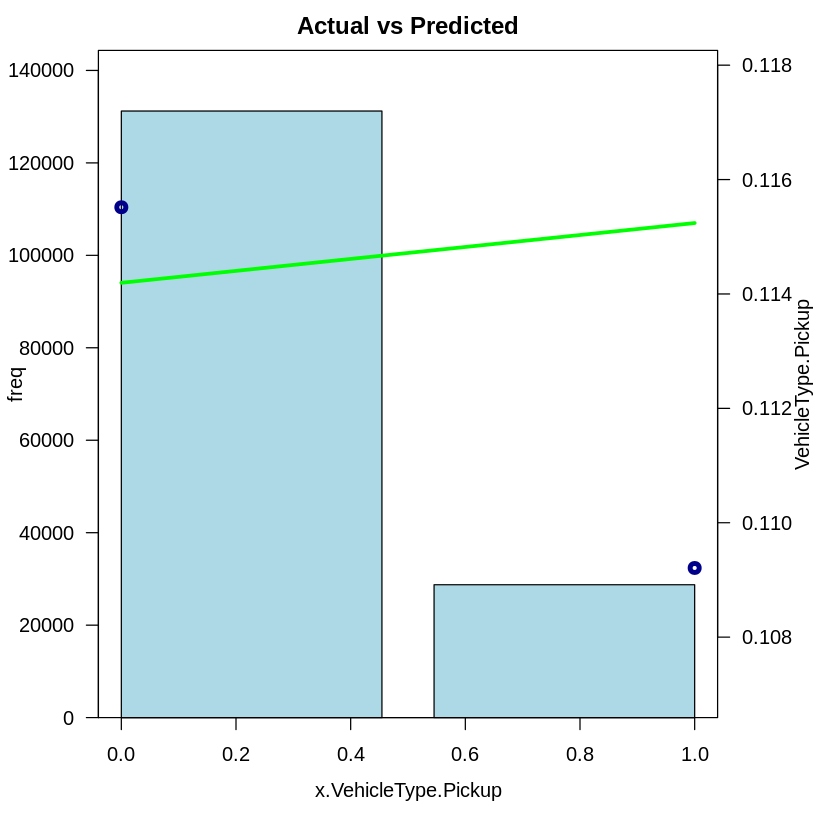

In [197]:
avse.plot.classification(var="x.VehicleType.Pickup",rt_text="VehicleType.Pickup",data=df.train.out,actual="y.train",pred="y.pred.train",weight="exposures",lt_text="freq")

,var,rel.inf
,<chr>,<dbl>
x.Age,x.Age,59.9911830
x.Tenure,x.Tenure,11.2775730
x.Territory.U,x.Territory.U,7.7980195
x.V1,x.V1,6.8479378
x.V2,x.V2,6.1407653
x.VehicleType.Other,x.VehicleType.Other,3.3414660
x.MaritalStatus.M,x.MaritalStatus.M,2.3552747
x.Gender.M,x.Gender.M,0.9490110
x.V3,x.V3,0.9247080


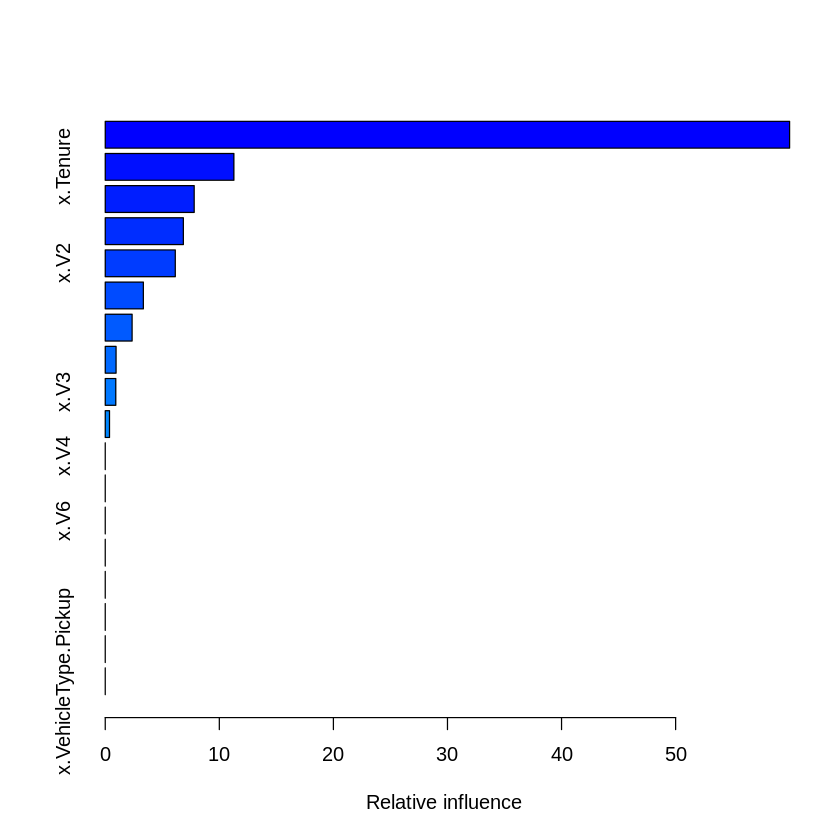

In [196]:
summary.gbm(m.gbm)

In [168]:
summary(df.train.out)

     x.Age         x.Gender.M     x.MaritalStatus.M    x.Tenure    
 Min.   :16.00   Min.   :0.0000   Min.   :0.0000    Min.   : 0.00  
 1st Qu.:37.00   1st Qu.:0.0000   1st Qu.:0.0000    1st Qu.: 8.00  
 Median :53.00   Median :0.0000   Median :1.0000    Median :13.00  
 Mean   :53.07   Mean   :0.4986   Mean   :0.5498    Mean   :12.38  
 3rd Qu.:70.00   3rd Qu.:1.0000   3rd Qu.:1.0000    3rd Qu.:17.00  
 Max.   :90.00   Max.   :1.0000   Max.   :1.0000    Max.   :20.00  
 x.Territory.U         x.V1             x.V2             x.V3     
 Min.   :0.0000   Min.   : 1.000   Min.   : 1.000   Min.   : 1.0  
 1st Qu.:0.0000   1st Qu.: 3.000   1st Qu.: 3.000   1st Qu.: 7.0  
 Median :0.0000   Median : 6.000   Median : 5.000   Median :10.0  
 Mean   :0.1987   Mean   : 5.506   Mean   : 5.499   Mean   :10.5  
 3rd Qu.:0.0000   3rd Qu.: 8.000   3rd Qu.: 8.000   3rd Qu.:14.0  
 Max.   :1.0000   Max.   :10.000   Max.   :10.000   Max.   :20.0  
      x.V4            x.V5             x.V6           x

In [109]:
summary(y.train)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.0000  0.0000  0.0000  0.1072  0.0000  1.0000 

In [92]:
summary(df.train)

     x.Age         x.Gender.M     x.MaritalStatus.M    x.Tenure    
 Min.   :16.00   Min.   :0.0000   Min.   :0.0000    Min.   : 0.00  
 1st Qu.:36.00   1st Qu.:0.0000   1st Qu.:0.0000    1st Qu.: 8.00  
 Median :53.00   Median :0.0000   Median :1.0000    Median :13.00  
 Mean   :52.88   Mean   :0.4993   Mean   :0.5472    Mean   :12.34  
 3rd Qu.:69.00   3rd Qu.:1.0000   3rd Qu.:1.0000    3rd Qu.:17.00  
 Max.   :90.00   Max.   :1.0000   Max.   :1.0000    Max.   :20.00  
 x.Territory.U      x.V1             x.V2             x.V3      
 Min.   :0.0   Min.   : 1.000   Min.   : 1.000   Min.   : 1.00  
 1st Qu.:0.0   1st Qu.: 3.000   1st Qu.: 3.000   1st Qu.: 7.00  
 Median :0.0   Median : 6.000   Median : 6.000   Median :10.00  
 Mean   :0.2   Mean   : 5.514   Mean   : 5.508   Mean   :10.51  
 3rd Qu.:0.0   3rd Qu.: 8.000   3rd Qu.: 8.000   3rd Qu.:14.00  
 Max.   :1.0   Max.   :10.000   Max.   :10.000   Max.   :20.00  
      x.V4             x.V5             x.V6           x.V7       
 M

# Load CSV datafile - Data split as train and test (80/20 split) and stored in git

*   Train data - Used for model training
*   Test data - Hold out data used for evaluating model performance

In [ ]:
# train_file <- "https://raw.github.com/aparnasree2020/sampledata_casws/master/Unbalanced_train_clean.csv"
# test_file <- "https://raw.github.com/aparnasree2020/sampledata_casws/master/Unbalanced_test_clean.csv"
# train_data <- read.csv(file =train_file, header = TRUE )
# test_data <- read.csv(file =test_file, header = TRUE )
# x_train <- train_data[, !names(train_data) %in% "claim_count_pd"]
# y_train <- train_data$claim_count_pd
# x_test <- test_data[, !names(test_data) %in% "claim_count_pd"]
# y_test <- test_data$claim_count_pd

# Fit GLM model and Predict output for test data

In [ ]:
# Fit a GLM
# fit <- step(glm(y_train ~ ., data = x_train, family = "gaussian"), direction = "both", trace = FALSE)
# pred_y_test <- predict(fit, newdata = x_test, type = "response")
# pred_y_test_bin = ifelse(pred_y_test > 0.5, 1, 0)
# dataout_GLM <- data.frame(pred_y_test_bin, y_test)
#write.csv(dataout_GLM, "GLM_stepwise_allfeatures.csv", row.names=FALSE)


#Fit GBM model and Predict output for test with standard hyperparameters

In [ ]:
# fit <- gbm(y_train ~ ., data = x_train, distribution = "gaussian", n.trees = 100, interaction.depth = 5)
# pred_y_test = predict.gbm(fit, x_test)
# pred_y_test_bin = ifelse(pred_y_test > 0.5, 1, 0)
# dataout_GBM <- data.frame(pred_y_test_bin, y_test)


Using 100 trees...




#XGboost with standard hyperparameters ( no tuning) 

In [ ]:
# fit <- xgboost(data = as.matrix(x_train), label = y_train, nrounds = 100, objective = "binary:logistic", eta = 0.3, max_depth = 6,silent = 1)
# pred_y_test <- predict(fit, as.matrix(x_test)) # Predict the classes for the test data
# pred_y_test_bin = ifelse(pred_y_test > 0.5, 1, 0)
# dataout_XGboost_simple <- data.frame(pred_y_test_bin, y_test)

#Calcualte the metric for each model

In [ ]:
# Define a function to compute the metrics for one model
compute_model_metrics <- function(pred, true, var_name) {
  tn <- sum((pred == 0) & (true == 0))
  fp <- sum((pred == 1) & (true == 0))
  fn <- sum((pred == 0) & (true == 1))
  tp <- sum((pred == 1) & (true == 1))
  total <- length(pred)
  
  accuracy <- (tp + tn) / total
  precision <- tp / (tp + fp)
  sensitivity <- tp / (tp + fn)
  f1_score <- 2 * precision * sensitivity / (precision + sensitivity)
  
  roc <- roc(true, pred)
  auc <- auc(roc)
  gini <- (auc * 2) - 1
  
  # Create a data frame to store the metrics
  metrics_df <- data.frame(var_name = var_name,
                           accuracy = accuracy,
                           precision = precision,
                           sensitivity = sensitivity,
                           f1_score = f1_score,
                           roc_auc = auc,
                           gini = gini,
                           TP = tp,
                           FP = fp,
                           TN = tn,
                           FN = fn,
                           Samples = total)
  
  # Return the data frame
  return(metrics_df)
}
# Compute the metrics for each model and combine the resulting data frames
metrics_df <- rbind(compute_model_metrics(dataout_XGboost_simple$pred_y_test_bin, dataout_XGboost_simple$y_test, "XGBoost"),
                    compute_model_metrics(dataout_GBM$pred_y_test_bin, dataout_XGboost_simple$y_test, "GBM"),
                    compute_model_metrics(dataout_GLM$pred_y_test_bin, dataout_GLM$y_test, "GLM"))
#print(metrics_df)

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



# Pretty print table of metrics

In [ ]:
knitr::kable(metrics_df,digits = 2)



|var_name | accuracy| precision| sensitivity| f1_score|   roc_auc| gini|  TP| FP|    TN|   FN| Samples|
|:--------|--------:|---------:|-----------:|--------:|---------:|----:|---:|--:|-----:|----:|-------:|
|XGBoost  |     0.91|      0.98|        0.07|     0.13| 0.5360971| 0.07| 580|  9| 71971| 7440|   80000|
|GBM      |     0.90|      1.00|        0.00|     0.00| 0.5001247| 0.00|   2|  0| 71980| 8018|   80000|
|GLM      |     0.90|      0.50|        0.00|     0.00| 0.5001108| 0.00|   2|  2| 71978| 8018|   80000|

#Plot the various metrics as plots

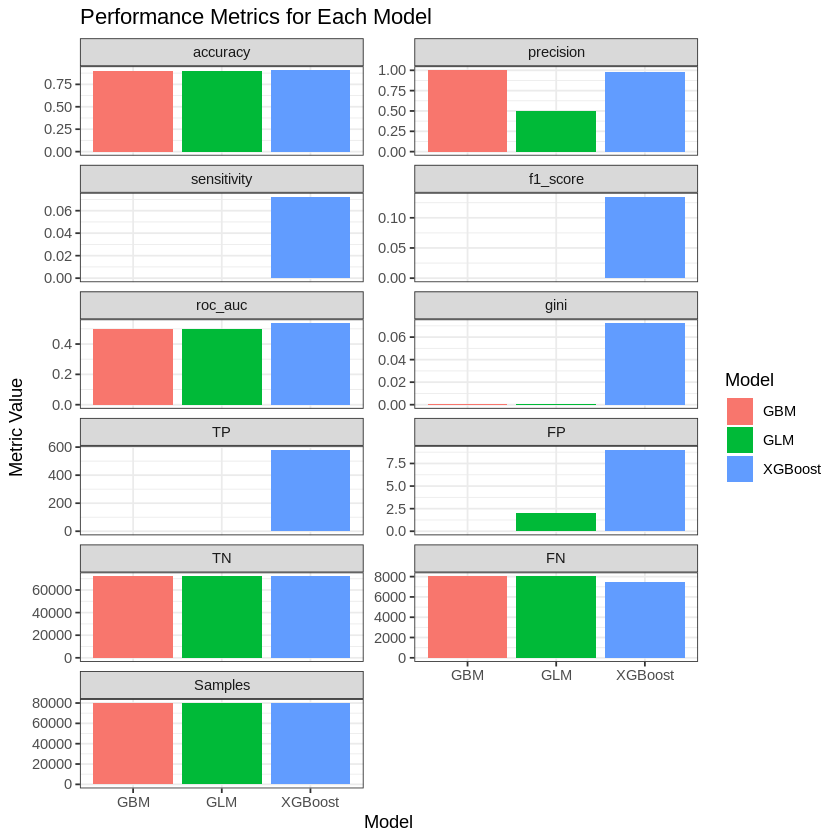

In [ ]:
options(warn=-1)
# Melt the data frame to a long format for plotting
metrics_df_melt <- melt(metrics_df, id.vars = "var_name", variable.name = "metric")

# Plot each performance metric for each model using ggplot2 and facet_wrap()
ggplot(metrics_df_melt, aes(x = var_name, y = value, fill = var_name)) +
  geom_bar(stat = "identity", position = "dodge") +
  labs(x = "Model", y = "Metric Value", fill = "Model") +
  ggtitle("Performance Metrics for Each Model") +
  facet_wrap(~metric, scales = "free_y", nrow = 10) +
  theme_bw() +
  theme(plot.background = element_rect(fill = "white", size = 4),
        panel.background = element_rect(fill = "white", size = 4))

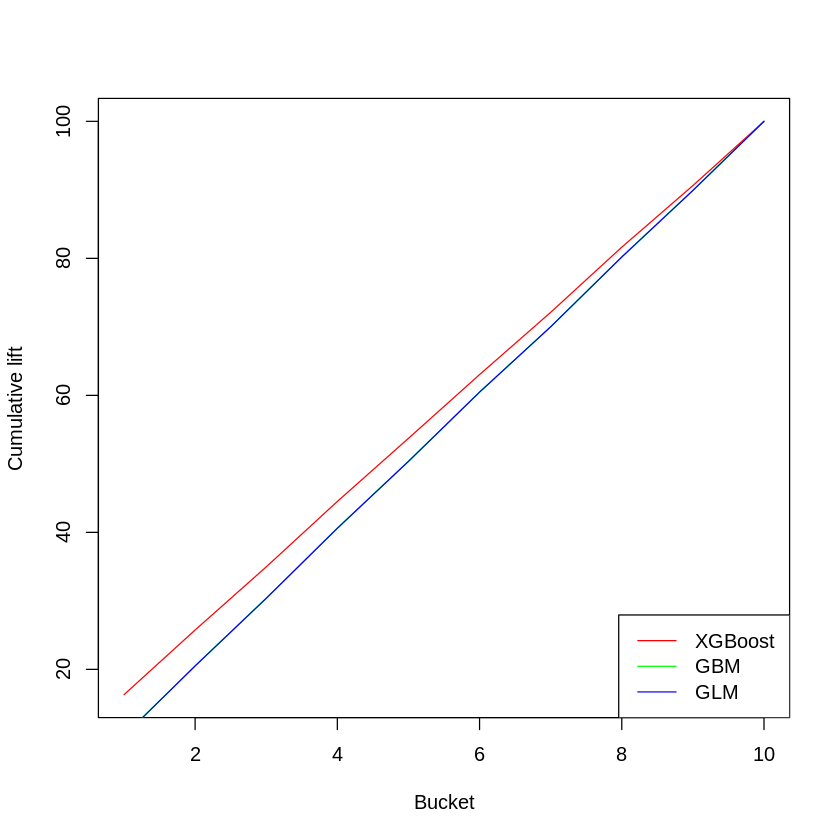

In [ ]:
library(dplyr)
options(warn=-1)
# Define the lift function
lift <- function(depvar, predcol, groups=10) {
  if(!require(dplyr)) {
    install.packages("dplyr")
    library(dplyr)
  }
  if(is.factor(depvar)) depvar <- as.integer(as.character(depvar))
  if(is.factor(predcol)) predcol <- as.integer(as.character(predcol))
  helper = data.frame(cbind(depvar, predcol))
  helper[,"bucket"] = ntile(-helper[,"predcol"], groups)
  gaintable = helper %>% group_by(bucket)  %>%
    summarise_at(vars(depvar), funs(total = n(),
                                    totalresp=sum(., na.rm = TRUE))) %>%
    mutate(Cumresp = cumsum(totalresp),
           Gain=Cumresp/sum(totalresp)*100,
           Cumlift=Gain/(bucket*(100/groups)))
  return(gaintable)
}

# Example usage
dt1 <- lift(dataout_XGboost_simple$y_test, dataout_XGboost_simple$pred_y_test_bin, groups = 10)
dt2 <- lift(dataout_GBM$y_test, dataout_GBM$pred_y_test_bin, groups = 10)
dt3 <- lift(dataout_GLM$y_test, dataout_GLM$pred_y_test_bin, groups = 10)

# Plot the lift charts with different colors
graphics::plot(dt1$bucket, dt1$Gain, type="l", ylab="Cumulative lift", xlab="Bucket", col="red",linetype = "dashed")
lines(dt2$bucket, dt2$Gain, col="green")
lines(dt3$bucket, dt3$Gain, col="blue",linetype = "dashed")
legend("bottomright", legend=c("XGBoost", "GBM", "GLM"), col=c("red", "green", "blue"), lty=1)

# End

Unused code below

In [ ]:
#library(Hmisc)
#hist.data.frame(gbm_data$claim_count_pd)

In [ ]:
#library(flextable)
# Convert the data frame to a flextable object
ft_metrics <- flextable(metrics_df)
ft_metrics <- set_formatter(ft_metrics, type = "numeric", digits = 2) # Set the number of decimal places for numeric columns

ft_metrics <- set_header_labels(ft_metrics, var_name = "Model", Samples = "Total Samples")
ft_metrics <- autofit(ft_metrics)
ft_metrics <- add_header_row(ft_metrics, values = "Performance Metrics", merge = 11)
print(ft_metrics)